<a href="https://colab.research.google.com/github/khanma1962/Fire_Detection_Faster_RCNN/blob/main/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection Using Faster R-CNN

# Paper Referred

https://arxiv.org/pdf/1506.01497.pdf

### Github Repository
https://github.com/pytorch/vision/tree/master/references/detection

### Faster R-CNN Tutorial from
https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.kaggle.com/moekhan/pytorch-starter-fasterrcnn-train/edit

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py

# Labelling Tools used
https://github.com/tzutalin/labelImg


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Calling Libraries

In [2]:
# Calling all the libraries
import numpy as np
import pandas as pd
import torch
import torchvision 
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os


In [3]:
# checking for cuda
if (torch.cuda.is_available()):
    device = torch.device('cuda')
    print(f'device is {device} and device name is {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print(f'Connected to {str(device).upper()}')


device is cuda and device name is Tesla P100-PCIE-16GB


In [4]:
!nvidia-smi

Fri Jul 23 02:08:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    30W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset

In [5]:
# copy google drive files to colab directories
!rm -r /content/data/
!cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data_10files/ .

main_dir = '/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System'
train_dir = '/content/data_10files/'
# test_dir  = '/content/data/validation/images/'

#read the .csv box with bounding box details
train_df = pd.read_csv('/content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/myvisionai_7_20_21.csv')
# test_df  = pd.read_csv('/content/data/validation/myvisionai-7-18-2021.csv')
# print(f'Shape of the train df is {train_df.shape} and test df 8\n')
# num_pic = len(train_df['filename'].unique())
# print(f'Unique pics are {num_pic}\n')
# train_df.head()


rm: cannot remove '/content/data/': No such file or directory


In [6]:
train_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Fire_30.jpg,296,170,fire,149,61,253,170
1,Fire_30.jpg,296,170,fire,59,5,187,63
2,Fire_31.jpg,311,162,fire,5,32,131,162
3,Fire_31.jpg,311,162,fire,203,3,311,162
4,Fire_31.jpg,311,162,fire,132,76,204,161
5,Fire_33.jpg,275,183,fire,1,68,140,132
6,Fire_35.jpg,266,189,fire,45,49,90,138
7,Fire_35.jpg,266,189,fire,97,60,145,122
8,Fire_35.jpg,266,189,fire,11,71,43,126
9,Fire_37.jpg,275,183,fire,101,4,255,112


In [7]:
# checking number of files in train and test
for path, dir, fils in os.walk(train_dir):
    print(f'{path} has {len(os.listdir(path))}')

# for path, dir, fils in os.walk(test_dir):
#     print(f'{path} has {len(os.listdir(path))}')
# # len(os.listdir(test_dir))

/content/data_10files/ has 10


Image size is (182, 276, 3)


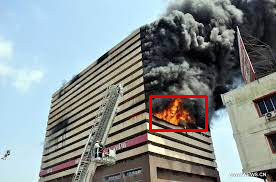

In [8]:
#plot a picture
pic_name = 'Fire_38.jpg'
image = cv2.imread(train_dir + pic_name)
print(f'Image size is {image.shape}')

xmin = train_df[train_df['filename']== pic_name]['xmin'].values
ymin = train_df[train_df['filename']== pic_name]['ymin'].values
xmax = train_df[train_df['filename']== pic_name]['xmax'].values
ymax = train_df[train_df['filename']== pic_name]['ymax'].values

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(image)


In [9]:
# Creating FireDataseet class
class FireDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms= None):
        super().__init__()

        self.image_ids = dataframe['filename'].unique()
        # print(f'self.image_ids is {self.image_ids.shape}')
        self.df = dataframe
        self.image_dir = image_dir
        # print('new',self.image_dir)
        self.transforms = transforms

    def __getitem__(self, index: int):
        # print(f'index is {index} and image_id is {self.image_ids[index]}')
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]

        # read image into cv2 format
        
        full_filename = f'{self.image_dir}{image_id}'
        image = Image.open(full_filename).convert('RGB')
        
        # image = cv2.imread(full_filename, cv2.IMREAD_COLOR)#Image.open
        # print(f'image_dir is {full_filename}, image_id is {image_id}, image_shape is {image.shape}  ')
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float)
        # image = image / 255.

        # find are based on xmin, ymin, xman, and yman
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # print(f'boxes is {boxes}')
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        # print(f'area is {area}')

        # conver boxes and are into tensors
        
        boxes = torch.as_tensor(boxes, dtype= torch.float32)
        
        area  = torch.as_tensor(area, dtype=torch.float32)

        # there is one class only
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        # print('here')
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
        

        # create a dictionary target
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # print('there')

        # # transforms
        if self.transforms is not None:
            # image, target  = self.transforms(image, target)
            image  = self.transforms(image)
            # image = torchvision.transforms.ToTensor()(image)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]



In [10]:
# collate function
# each element of dataset returns tupe(image, target) instead of a single value
def collate_function(batch):
    return tuple(zip(*batch))

def get_transform(train):
    transforms = []
    # conver PIL to Tensor
    transforms.append(T.ToTensor())
    if train:
        # flip images during training 
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


batch_size = 2
img_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22
# train_transform = transforms.Compose([
#                             # transforms.RandomRotation(degrees=(10,10)), # rotate + / - 10 degree
#                             # transforms.RandomRotation(degrees=(90,90)), 
#                             # transforms.RandomRotation(degrees=(270,270)), 
#                             # transforms.RandomHorizontalFlip(), # reverse 50% of images
#                             # transforms.RandomVerticalFlip(p=1),
#                             # transforms.ColorJitter(),
                            
#                             # transforms.Resize(img_size),
#                             # transforms.CenterCrop(img_size),
#                             # transforms.ToPILImage(),
#                             transforms.ToTensor(),
#                             transforms.Normalize(mean,std)  
#                                       ])

# test_transform = transforms.Compose([
                          
#                             transforms.Resize(img_size),
#                             transforms.CenterCrop(img_size),
#                             transforms.ToPILImage(),
#                             transforms.ToTensor(),
#                             transforms.Normalize(mean,std)   
                                    #   ])



# train and test datasets
train_dataset = FireDataset(train_df, train_dir, get_transform(train=True) )
# test_dataset  = FireDataset(test_df, test_dir, test_transform)

#train and test dataloader
train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers =0,
                               collate_fn = collate_function)

# test_data_loader = DataLoader(test_dataset,
#                                batch_size=batch_size,
#                                shuffle=False,
#                                num_workers =2,
#                                collate_fn = collate_function)

In [11]:
for images, targets in train_data_loader:
    break
print(f'image.shape is {images[0].shape}\n')
print(f'targets are {targets}')

image.shape is torch.Size([3, 183, 275])

targets are ({'boxes': tensor([[  1.,  68., 140., 132.]]), 'labels': tensor([1]), 'image_id': tensor([2]), 'area': tensor([8896.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[  5.,  32., 131., 162.],
        [203.,   3., 311., 162.],
        [132.,  76., 204., 161.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([1]), 'area': tensor([16380., 17172.,  6120.]), 'iscrowd': tensor([0, 0, 0])})


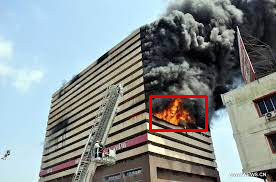

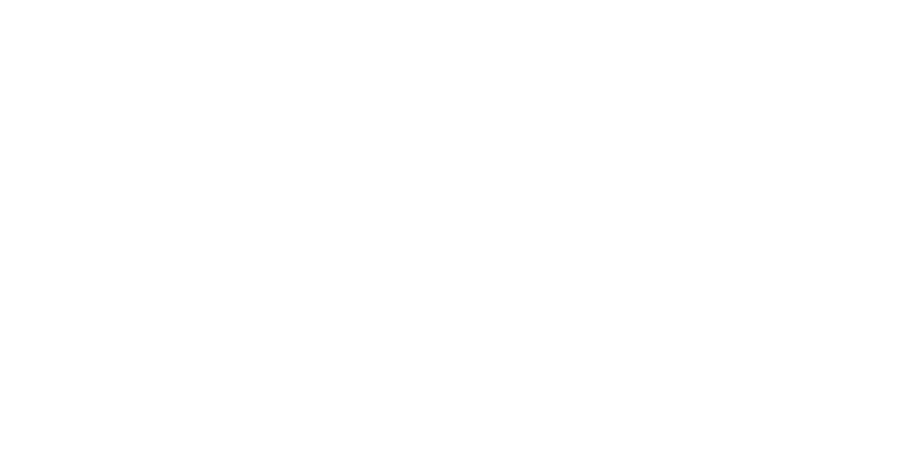

In [12]:
# let's see some images
# read first batch from train_data_loader
images, targets = next(iter(train_data_loader))

#send image to device
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1, 2, 0).cpu().numpy() # permute rearrange to 1,2,0 axis

fig, ax = plt.subplots(1, 1, figsize=(16,8))

for box in boxes:
    cv2.rectangle(img,
                 (box[0], box[1]),
                 (box[2], box[3]),
                 (0, 0, 225),
                  3)
ax.set_axis_off()
# ax.imshow(img)

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
# image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(image);


# Pre-trained Model from torchvision


In [13]:
#Fine Tuning Pre-Trained Model
#load a pre-trained model with resnet50 as backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one
num_classes = 2 # 1 class(fire) and 0(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head wit the new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



# Train

In [15]:
# Training parameters
num_epochs = 5 #100

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.006, momentum = 0.9, weight_decay= 0.006)
lr_scheduler = None
itr = 1


for epoch in range(num_epochs):

    for images, targets in train_data_loader:
        
        #send images and targets to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]


        loss_dict = model(images, targets)
        # print(f'loss dict is {loss_dict}')
        losses = sum(loss for loss in loss_dict.values())
        # print(f'losses are {losses} ')
        loss_value = losses.item()

        optimizer.zero_grad() # to clear old gradient to zero
        losses.backward() # back prop for required_grade = True
        optimizer.step() # update parameter based on parameter.grad

        if itr % 20 == 0:
            print(f'Iterattion #{iter}  loss: {loss_value}')

        itr += 1
        if lr_scheduler is not None:
            lr_scheduler.step() # for adjusting the learning rate

    print(f'Epoch #{epoch+1} loss: {loss_value}')


# save model    
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
# torch.save({
#         'epoch' : epoch,
#         'model_state_dict' : model.state_dict(),
#         'optimzer-state_dict' : optimizer.state_dict,
# }, main_dir)





Epoch #1 loss: 0.17329344153404236
Epoch #2 loss: 0.21220625936985016
Epoch #3 loss: 0.18595440685749054
Iterattion #<built-in function iter>  loss: 0.1526476889848709
Epoch #4 loss: 0.1526476889848709
Epoch #5 loss: 0.30763378739356995
